# Kernel Density Estimate and Kernel Regression

This notebook uses non-parametric methods to estimate distributions and regressions.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics, StatsBase

include("jlFiles/printmat.jl")
include("jlFiles/NWFn.jl")
include("jlFiles/OlsFn.jl")

OlsFn

In [2]:
using Plots

#pyplot(size=(600,400))        #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

The data consists of daily returns on U.S. large caps.

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
R   = xx[:,11]            #returns for the size portfolio we want to study
xx  = nothing

y   = R[2:end]            #dependent variable
x   = R[1:end-1]          #regressor
T   = size(x,1)

println("Sample size: $T")

Sample size: 8324


# Kernel Density Estimate

The `KernDensFn()` function (below) estimates the probability density function (pdf). The bandwidth parameter (`h`) can be supplied by the call, but otherwise defaults to the rule of thumb value $h=1.06\textrm{std}(x)/T^{0.2}$.

The function outputs both the estimate the estimate of $\textrm{pdf}(x)$, denoted `fx`, and its standard deviation, denoted `Stdfx`.

As an alternative to this code, consider the [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl) package.

In [4]:
"""
    KernDensFn(x,xGrid,h=[])

Compute a kernel density estimate at each value of the grid `xGrid`, using the data in vector `x`. 
The bandwidth `h` can be specified (otherwise a default value is used.) 
"""
function KernDensFn(x,xGrid,h=[])

    if isempty(h)
        h = 1.06*std(x)/T^0.2
    end

    Ngrid = length(xGrid)                          #number of grid points
    fx    = fill(NaN,Ngrid)
    for j = 1:Ngrid                                #loop over elements in xGrid
        xa    = (x .- xGrid[j])/h
        Kh    = exp.(-(xa.^2)/2)/(h*sqrt(2*pi))    #gaussian kernel, with "std" = h
        fx[j] = mean(Kh)
    end

    Varfx = fx./(T*h) * 1/(2*sqrt(pi))
    Stdfx = sqrt.(Varfx)                            #std[f(x)]

  return fx, Stdfx

end

KernDensFn

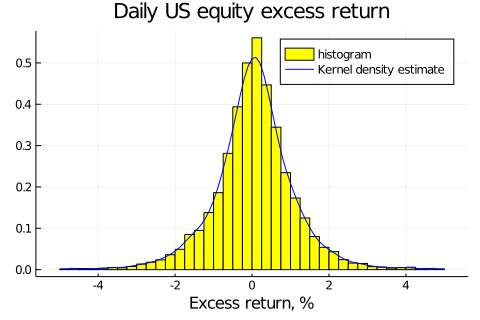

In [5]:
xGrid = -5:0.1:5
pdfX, = KernDensFn(x,xGrid)

p1 = histogram( x,bins = -5:0.25:5,
                normalized = true,
                fillcolor = :yellow,
                label = "histogram",
                title = "Daily US equity excess return",
                xlabel = "Excess return, %" )
plot!(xGrid,pdfX,linewidth=1,color=:blue,label="Kernel density estimate")
display(p1)

# Kernel Regression

We regress the daily return on the lagged daily return, that is, a non-parametric AR(1)

$
R_t = b(R_{t-1}) + \epsilon_t
$


A kernel regression is of the form

$
\hat{b}(x)=\frac{\sum_{t=1}^{T}w(x_t-x)y_{t}}{\sum_{t=1}^{T}w(x_t-x)},
$

where $w(x_t-x)$ is the weight of observation $t$, defined by a kernel function.

The function KernRegFn uses a normal kernel, $N(x,h^{2})$.

The function `KernRegFn()` estimates $b(x)$ at each point $x$ in the vector `xGrid`. The function requires the user to input a bandwidth parameter `h`.

## Point Estimates

In [6]:
"""
    KernRegFn(y,x,xGrid,h,vv)

Do kernel regression y[vv] = b(x[vv]), evaluated at xGrid vector, using bandwidth h.

"""
function KernRegFn(y,x,xGrid,h,vv)

    Ngrid = length(xGrid)                  #number of grid points

    bHat = fill(NaN,Ngrid)                 #b[x(t)]
    for i = 1:Ngrid                        #loop over elements in xGrid
        zi      = (x .- xGrid[i])/h
        w       = exp.(-zi.^2/2)./(h*sqrt(2*pi))       #gaussian kernel, with "std" = h
        bHat[i] = sum(w[vv].*y[vv])/sum(w[vv])         #sum over observations, indexed vv
    end

    return bHat

end

KernRegFn

In [7]:
xGrid = -10:0.25:10                          #x values to estimate b(x) at
h     = 1.5
bHat    = KernRegFn(y,x,xGrid,h,1:T)         #baseline choice of h
bHatHih = KernRegFn(y,x,xGrid,h*2,1:T)       #high h
bHatLoh = KernRegFn(y,x,xGrid,h*0.5,1:T);    #low h

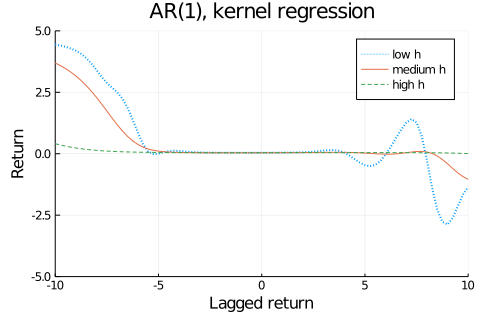

In [8]:
p1 = plot( xGrid,[bHatLoh bHat bHatHih],
           linestyle = [:dot :solid :dash],
           linewidth = [2 1 1],
           label = ["low h" "medium h" "high h"],
           xlim = extrema(xGrid),
           ylim = (-5,5),
           title = "AR(1), kernel regression",
           xlabel = "Lagged return",
           ylabel = "Return" )
display(p1)

## Rule of Thumb Choice of h

Run the regression 

$
y=\alpha+\beta x+\gamma x^{2}+\varepsilon
$

and use the following rule-of-thumb choice

$
h  =T^{-1/5}|\gamma|^{-2/5}\sigma_{\varepsilon}^{2/5}(x_{\max}-x_{\min})^{1/5}\times0.6.
$

In practice, replace $x_{\max}-x_{\min}$ by the difference between the 90th
and 10th percentiles of $x$.

In [9]:
"""
    hRuleOfThumb(y,x)

Rule of thumb bandwidth for regressing y on x.
"""
function hRuleOfThumb(y,x)

    (b,res,)     = OlsFn(y,[x.^2 x ones(T)])
    (σ,γ)        = (std(res), b[1])
    (x_10,x_90)  = quantile(x,[0.1,0.9])             #10th and 90th percentiles

    h_rot = 0.6*σ^(2/5)*abs(γ)^(-2/5)*(x_90-x_10)^(1/5)*T^(-1/5)

    return h_rot
end

h_crude = hRuleOfThumb(y,x)
printlnPs("\nRule-of-thumb value of h: ",h_crude)


Rule-of-thumb value of h:      0.667


## Confidence Bands for the Kernel Regression

The function `KernRegFn` constructs a confidence band around the estimates of $b(x)$. To do that several steps are required.

1.  Estimate $b(x)$ at all $x$ values in the data set and construct residuals, `eHat`
2.  Regress (non-parametrically) `eHat^2` on x, using a rule of thumb bandwidth
3.  Calculate a kernel density estimate of $x$
4.  Combine the results using the formula for the asymptotic variance:

$
\textrm{var}[\hat{b}(x)]=  \frac{1}{2\sqrt{\pi}}\frac{\sigma^{2}(x)}{f(x)}\frac{1}{Th}
$

In [10]:
"""
KernRegStd(y,x,xGrid,h)

Calculate std[bhat(x)] where bhat is the fitted kernel regression function evaluated at x.
"""
function KernRegStd(y,x,xGrid,h)

    bHat = KernRegFn(y,x,x,h,1:length(y))
    eHat = y .- bHat

    h_σ²      = hRuleOfThumb(eHat.^2,x)
    sigma2Hat = KernRegFn(eHat.^2,x,xGrid,h_σ²,1:length(eHat))
    fx,       = KernDensFn(x,xGrid)

    VarbHat   = 1/(2*sqrt(pi))*sigma2Hat./(fx*h*T)
    StdbHat   = sqrt.(VarbHat)

    return StdbHat
 
end

KernRegStd

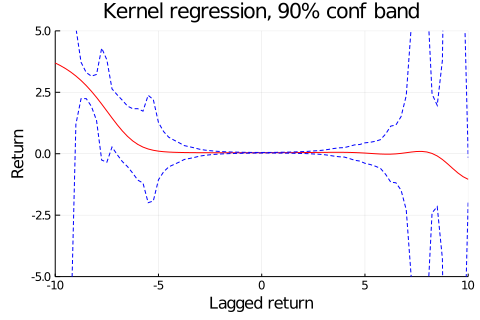

In [11]:
StdbHat = KernRegStd(y,x,xGrid,h)

p1 = plot( xGrid,[bHat (bHat-1.645*StdbHat) bHat+1.645*StdbHat],
           linecolor = [:red :blue :blue],
           linestyle = [:solid :dash :dash],
           label = "",
           title = "Kernel regression, 90% conf band",
           xlabel = "Lagged return",
           ylabel = "Return",
           xlim = extrema(xGrid),
           ylim = (-5,5) )
display(p1)

## Cross-Validation  (extra)

To do a cross-validation (leave-one-out)

(1) Pick a bandwidth $h$, do the kernel regression
but leave out observation $t$ and then record the out-of-sample prediction error $y_{t}-\hat{b}_{-t}
(x_{t},h)$. Notice that this is the error for observation $t$ only. 

(2) Repeat for all $t=1-T$ to calculate the EPE

$
\text{EPE}(h)=\sum_{t=1}^{T}[  y_{t}-\hat{b}_{-t}(x_{t},h)]  ^{2}/T,
$

(3) Finally, redo for several different values of $h$---and pick the one
that minimizes EPE$(h)$. 

Notice: Cross-validation calculations *take some time*

In [12]:
hM = h_crude*[0.5;0.75;1;1.5;2;3;4;5;10]

Nh   = length(hM)
EPEM = fill(NaN,(T,Nh))
for t = 1:T
    local v_No_t, b_t
    v_No_t = setdiff(1:T,t)     #exclude t from estimation
    for j = 1:Nh
        b_t       = KernRegFn(y,x,x[t],hM[j],v_No_t)
        EPEM[t,j] = (y[t] - b_t[1])^2
    end
end

EPE = mean(EPEM,dims=1)'

printblue("Cross-validation of bandwidth (h)")
printTable([hM EPE],["h","EPE"],fill("",Nh))

Cross-validation of bandwidth (h)
         h       EPE
     0.334     1.314
     0.501     1.302
     0.667     1.295
     1.001     1.288
     1.335     1.286
     2.002     1.287
     2.670     1.291
     3.337     1.292
     6.674     1.296



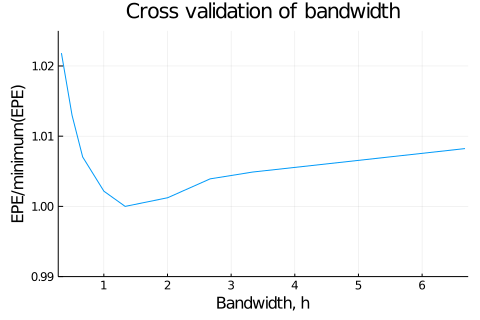

In [13]:
p1 = plot( hM,EPE/minimum(EPE),
           legend = false,
           xlim = (minimum(hM)-0.05,maximum(hM)+0.05),
           ylim = (0.99,1.025),
           title = "Cross validation of bandwidth",
           xlabel = "Bandwidth, h",
           ylabel = "EPE/minimum(EPE)" )
display(p1)